# **Swiss Train Station Analysis**

This notebook demonstrates a comprehensive analysis of Swiss train station data, which contains:

- **Bahnhof**: Station name
- **Kanton**: Swiss canton/province
- **DTV**: Average daily traffic
- **DWV**: Average workday traffic (Mon-Fri)
- **DNWV**: Average non-workday traffic (Sat, Sun, Holidays)
- **EVU**: Train operator
- **lon, lat**: Coordinates

We will walk through:
1. **Data Loading & Cleaning**
2. **Descriptive Statistics & Visualizations** (including how to handle skewed data)
3. **Chi-Squared Test** (Kanton vs. EVU)
4. **One-Way ANOVA** (DTV by Kanton)
5. **Correlation Analysis** (DTV, DWV, DNWV)

We also demonstrate how to handle **outliers** and **log-scale** transformations, given the highly skewed nature of traffic data.

## **Topic**: *Differences in Daily Traffic (DTV) Across Cantons*
We'll see if certain cantons have significantly different average daily traffic, and whether traffic is related to train operator.


In [20]:
# Standard library imports
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency, f_oneway, pearsonr, levene, shapiro

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for Jupyter inline plotting
%matplotlib inline


## 1. Data Loading & Cleaning

Replace `'stations.csv'` below with your actual CSV file if needed.
We assume your CSV has columns:
```
Code,UIC,Bahnhof,Kanton,ISB_GI,Jahr,DTV,DWV,DNWV,EVU,lon,lat
```
and ~3,471 rows. Here we load the data into a pandas DataFrame.


In [21]:
# Step 1: Load CSV
csv_file = 'data_prepared.csv'  # <-- Change if needed
df = pd.read_csv(csv_file)

print("DataFrame Shape:", df.shape)
df.head(10)

DataFrame Shape: (3470, 12)


,Code,UIC,Bahnhof,Kanton,ISB_GI,Jahr,DTV,DWV,DNWV,EVU,lon,lat
0,AAT,8503124,Aathal,ZH,SBB,2018,740,800,610,SBB,8.765625,47.335959
1,AB,8507472,Ausserberg,VS,BLS,2018,180,160,210,BLS,7.844167,46.312348
2,ABE,8504404,Aarberg,BE,SBB,2022,520,580,400,BLS,7.278693,47.044541
3,ABE,8504404,Aarberg,BE,SBB,2023,580,620,460,BLS,7.278693,47.044541
4,ABO,8502000,Aarburg-Oftringen,AG,SBB,2022,2500,2900,1500,SBB,7.908223,47.320268
5,ADZ,8509266,Ardez,GR,RhB,2018,240,250,240,RhB,10.201050,46.773540
6,AEF,8508085,Aefligen,BE,BLS,2023,410,480,250,BLS,7.559253,47.095594
7,ALLI,8501378,Allières,FR,MOB,2022,60,49,110,MOB,7.007890,46.469820
8,ALLI,8501378,Allières,FR,MOB,2023,50,50,60,MOB,7.007890,46.469820
9,ALN,8506125,Altnau,TG,SBB,2023,400,400,380,Thurbo,9.265918,47.621368


### 1.1 Check for Missing or Invalid Data
We check whether the columns we need are present, and how many missing values exist. If necessary, we can drop or impute them.

In [22]:
# Checking for missing values
df.isna().sum()

Code       0
UIC        0
Bahnhof    0
Kanton     0
ISB_GI     0
Jahr       0
DTV        0
DWV        0
DNWV       0
EVU        0
lon        0
lat        0
dtype: int64

If needed, we can **drop** rows with critical missing columns (e.g., `DTV`, `DWV`, `DNWV`, `Kanton`, `EVU`) or **impute** them. Below we demonstrate dropping them for clarity.

In [23]:
# We define a list of required columns for analysis
required_cols = ['Kanton','EVU','DTV','DWV','DNWV']
df.dropna(subset=required_cols, inplace=True)

# Convert numeric columns if they're strings
for col in ['DTV','DWV','DNWV','lon','lat']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows that still have NaN in these columns after conversion
df.dropna(subset=['DTV','DWV','DNWV','lon','lat'], inplace=True)

print("Final shape after cleaning:", df.shape)

Final shape after cleaning: (3470, 12)


## 2. Descriptive Statistics & Visualizations
Let's get a sense of the numeric columns, especially how skewed `DTV` might be.

In [24]:
# Basic descriptive stats for DTV, DWV, DNWV
df[['DTV','DWV','DNWV']].describe()

,DTV,DWV,DNWV
count,3470.000000,3470.000000,3470.000000
mean,3180.785303,3540.288761,2364.142939
std,14984.987634,16302.445578,12109.286142
min,49.000000,49.000000,49.000000
25%,210.000000,220.000000,150.000000
50%,590.000000,660.000000,410.000000
75%,1600.000000,1800.000000,1100.000000
max,423600.000000,471300.000000,349700.000000


### 2.1 Distribution of DTV
Traffic data can be **highly skewed**, with many small/medium stations and a few extremely large ones. Let's visualize it.

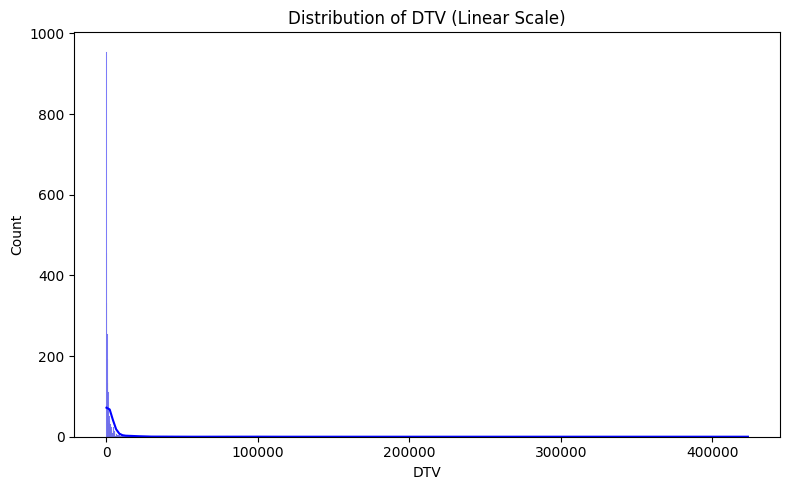

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='DTV', kde=True, color='blue')
plt.title('Distribution of DTV (Linear Scale)')
plt.xlabel('DTV')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Because the data are often **heavily skewed**, you might see a single spike near 0 and a very long tail. Let's also plot it on a **log scale** for better visibility.

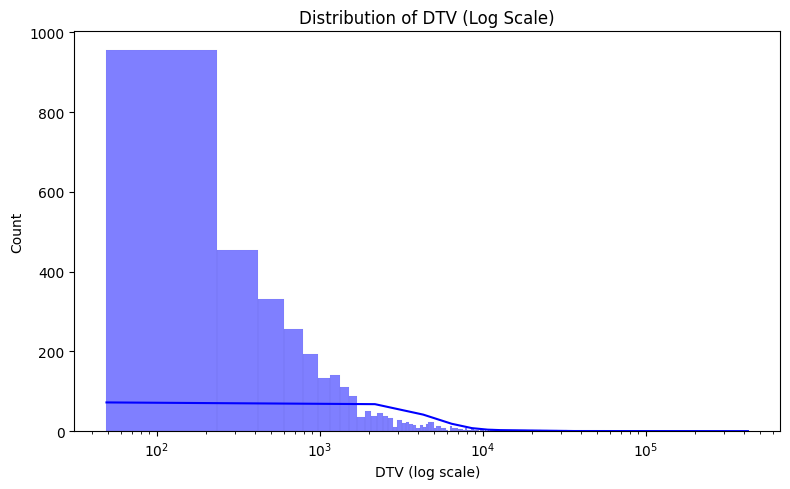

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='DTV', kde=True, color='blue')
plt.xscale('log')
plt.title('Distribution of DTV (Log Scale)')
plt.xlabel('DTV (log scale)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2.2 Descriptive Insights by Canton
Let's look at how many station entries there are per `Kanton`.

In [27]:
kanton_counts = df['Kanton'].value_counts()
kanton_counts

Kanton
BE    594
VD    411
ZH    399
GR    333
TG    198
AG    193
SG    184
VS    175
LU    153
TI    102
FR     96
SO     93
SZ     84
NE     80
BL     63
ZG     57
GE     56
GL     48
JU     40
OW     33
UR     30
NW     21
SH     12
BS      9
AR      6
Name: count, dtype: int64

Visualize counts per canton with a bar plot.

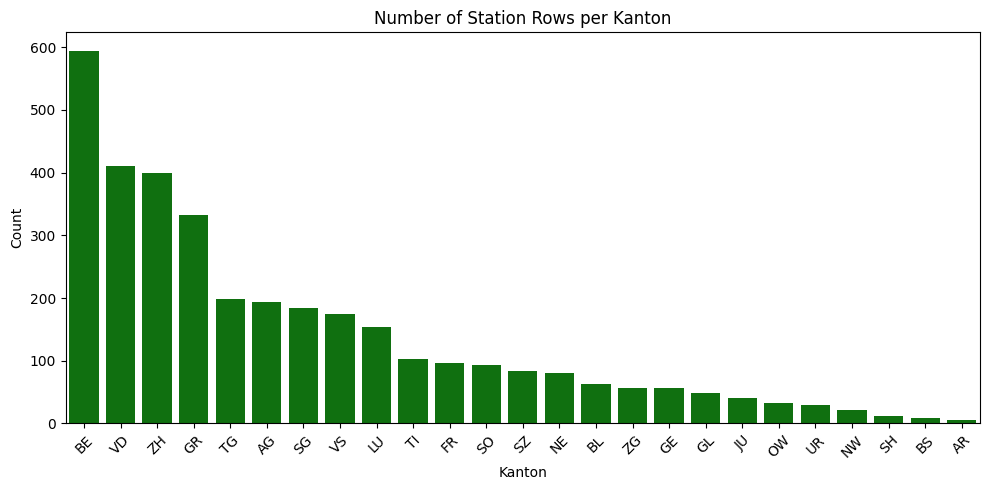

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(x=kanton_counts.index, y=kanton_counts.values, color='green')
plt.title('Number of Station Rows per Kanton')
plt.xlabel('Kanton')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Chi-Squared Test (Kanton vs. EVU)

We test the **association** between two categorical variables:
- `Kanton` (canton)
- `EVU` (train operator)

**Null Hypothesis (H0)**: There is *no* association between Kanton and EVU.

**Alternative (H1)**: There *is* some association (the distribution of EVU depends on Kanton or vice-versa).

In [29]:
contingency_table = pd.crosstab(df['Kanton'], df['EVU'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("--- Chi-Squared Test: Kanton vs EVU ---")
print("Chi2 Statistic:", chi2_stat)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequency Table:")
print(expected)

if p_value < 0.05:
    print("\nConclusion: p-value < 0.05 => There is a statistically significant association between Kanton and EVU.")
else:
    print("\nConclusion: p-value >= 0.05 => No strong evidence of association between Kanton and EVU.")

--- Chi-Squared Test: Kanton vs EVU ---
Chi2 Statistic: 20790.0265744777
p-value: 0.0
Degrees of Freedom: 1320
Expected Frequency Table:
[[1.66858790e-01 2.38051873e+01 2.22478386e-01 ... 5.56195965e-01
  1.51285303e+01 5.67319885e+00]
 [5.18731988e-03 7.40057637e-01 6.91642651e-03 ... 1.72910663e-02
  4.70317003e-01 1.76368876e-01]
 [5.13544669e-01 7.32657061e+01 6.84726225e-01 ... 1.71181556e+00
  4.65613833e+01 1.74605187e+01]
 ...
 [1.51296830e-01 2.15850144e+01 2.01729107e-01 ... 5.04322767e-01
  1.37175793e+01 5.14409222e+00]
 [4.92795389e-02 7.03054755e+00 6.57060519e-02 ... 1.64265130e-01
  4.46801153e+00 1.67550432e+00]
 [3.44956772e-01 4.92138329e+01 4.59942363e-01 ... 1.14985591e+00
  3.12760807e+01 1.17285303e+01]]

Conclusion: p-value < 0.05 => There is a statistically significant association between Kanton and EVU.


## 4. One-Way ANOVA (DTV by Kanton)

We want to see if the **mean DTV** differs significantly **across cantons**.

**Null Hypothesis (H0)**: All cantons have the *same* mean DTV.

**Alternative (H1)**: At least one canton has a different mean DTV.

### 4.1 Check ANOVA Assumptions
- **Normality** in each group (somewhat robust if sample sizes are large)
- **Homogeneity of variances** across groups


In [30]:
# Group the data by Kanton
grouped = df.groupby('Kanton')['DTV']
groups_list = [grouped.get_group(k) for k in grouped.groups]

# Levene's Test for equal variances
levene_stat, levene_p = levene(*groups_list)
print("--- Levene's Test for Homogeneity of Variances (DTV by Kanton) ---")
print("Levene Statistic:", levene_stat)
print("p-value:", levene_p)
if levene_p < 0.05:
    print("\nConclusion: p-value < 0.05 => Variances may not be equal.")
else:
    print("\nConclusion: p-value >= 0.05 => Variances are likely equal.")


--- Levene's Test for Homogeneity of Variances (DTV by Kanton) ---
Levene Statistic: 4.642075492465393
p-value: 5.650017669477684e-13

Conclusion: p-value < 0.05 => Variances may not be equal.


### 4.2 Perform ANOVA
We use `scipy.stats.f_oneway` for a one-way ANOVA.

In [31]:
f_stat, p_val = f_oneway(*groups_list)
print("\n--- One-Way ANOVA: DTV by Kanton ---")
print("F-statistic:", f_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("\nConclusion: p-value < 0.05 => At least one canton has a different mean DTV.")
else:
    print("\nConclusion: p-value >= 0.05 => No significant difference in mean DTV among cantons.")


--- One-Way ANOVA: DTV by Kanton ---
F-statistic: 5.3570256849428874
p-value: 6.301304916858232e-16

Conclusion: p-value < 0.05 => At least one canton has a different mean DTV.


#### 4.3 (Optional) Post-Hoc Test
If ANOVA is significant, you might want to know *which* cantons differ. You can use tools like **Tukey's HSD** from `statsmodels.sandbox.stats.multicomp`. 
This is optional, but recommended if you get a significant result and want to see pairwise differences.

In [32]:
# Install statsmodels if not already installed
%pip install statsmodels

from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Prepare data for Tukey
dtv_data = df[['Kanton','DTV']].dropna()
tukey = pairwise_tukeyhsd(endog=dtv_data['DTV'], groups=dtv_data['Kanton'], alpha=0.05)
print(tukey)

Note: you may need to restart the kernel to use updated packages.
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
    AG     AR   -724.4421    1.0 -23130.6641  21681.7798  False
    AG     BE   -716.6341    1.0  -5194.9205   3761.6523  False
    AG     BL   -213.2993    1.0  -8056.0322   7629.4337  False
    AG     BS  28993.8912    0.0  10561.9044   47425.878   True
    AG     FR  -1682.4317    1.0  -8432.8553   5067.9919  False
    AG     GE   3281.3912 0.9993  -4922.5659  11485.3483  False
    AG     GL  -2629.5046    1.0  -11347.279   6088.2697  False
    AG     GR  -2365.0187 0.9892  -7254.7892   2524.7518  False
    AG     JU  -2099.2838    1.0 -11489.2858   7290.7182  False
    AG     LU   -133.8212    1.0  -5984.5512   5716.9087  False
    AG     NE  -1393.1463    1.0  -8580.2523   5793.9597  False
    AG     NW  -1568.0136    1.0 -1398

## 5. Correlation Analyses
### 5.1 Correlation between DTV and DWV
We hypothesize DTV (average daily traffic) and DWV (average workday traffic) might be strongly correlated.

In [33]:
corr_coeff, corr_pval = pearsonr(df['DTV'], df['DWV'])
print("--- Pearson Correlation: DTV vs DWV ---")
print("Correlation Coefficient =", corr_coeff)
print("p-value =", corr_pval)

if corr_pval < 0.05:
    print("Conclusion: p-value < 0.05 => Significant correlation.")
else:
    print("Conclusion: p-value >= 0.05 => Not significant.")

--- Pearson Correlation: DTV vs DWV ---
Correlation Coefficient = 0.9992680623218131
p-value = 0.0
Conclusion: p-value < 0.05 => Significant correlation.


### 5.2 Correlation between DTV and DNWV

In [34]:
corr_coeff_dnwv, corr_pval_dnwv = pearsonr(df['DTV'], df['DNWV'])
print("\n--- Pearson Correlation: DTV vs DNWV ---")
print("Correlation Coefficient =", corr_coeff_dnwv)
print("p-value =", corr_pval_dnwv)

if corr_pval_dnwv < 0.05:
    print("Conclusion: p-value < 0.05 => Significant correlation.")
else:
    print("Conclusion: p-value >= 0.05 => Not significant.")


--- Pearson Correlation: DTV vs DNWV ---
Correlation Coefficient = 0.9934791778484287
p-value = 0.0
Conclusion: p-value < 0.05 => Significant correlation.


### 5.3 Correlation between DWV and DNWV

In [35]:
corr_coeff_wv_nwv, corr_pval_wv_nwv = pearsonr(df['DWV'], df['DNWV'])
print("\n--- Pearson Correlation: DWV vs DNWV ---")
print("Correlation Coefficient =", corr_coeff_wv_nwv)
print("p-value =", corr_pval_wv_nwv)

if corr_pval_wv_nwv < 0.05:
    print("Conclusion: p-value < 0.05 => Significant correlation.")
else:
    print("Conclusion: p-value >= 0.05 => Not significant.")


--- Pearson Correlation: DWV vs DNWV ---
Correlation Coefficient = 0.9884006131194009
p-value = 0.0
Conclusion: p-value < 0.05 => Significant correlation.


### 5.4 Correlation Matrix & Heatmap
A quick overview of correlations among `DTV`, `DWV`, and `DNWV`.


Correlation Matrix:
           DTV       DWV      DNWV
DTV   1.000000  0.999268  0.993479
DWV   0.999268  1.000000  0.988401
DNWV  0.993479  0.988401  1.000000


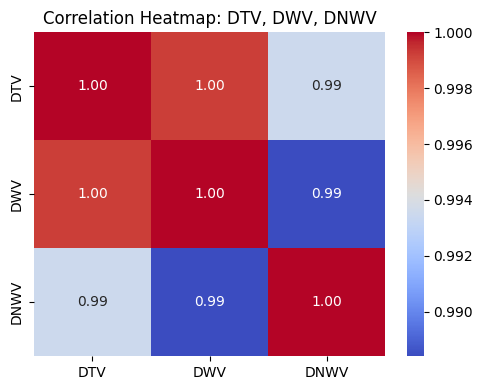

In [36]:
num_cols = ['DTV','DWV','DNWV']
corr_matrix = df[num_cols].corr(method='pearson')
print("\nCorrelation Matrix:")
print(corr_matrix)

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: DTV, DWV, DNWV')
plt.tight_layout()
plt.show()

## 6. Additional Insights / Handling Outliers

Given the extreme skew in `DTV`, you might:
1. Use **log-scale** in your plots.
2. **Cap** or **clip** outliers above a certain percentile (e.g., 99th).
3. Investigate large stations individually.

Below is an example of **clipping** at the 99th percentile, then re-plotting the distribution to see the core data more clearly.

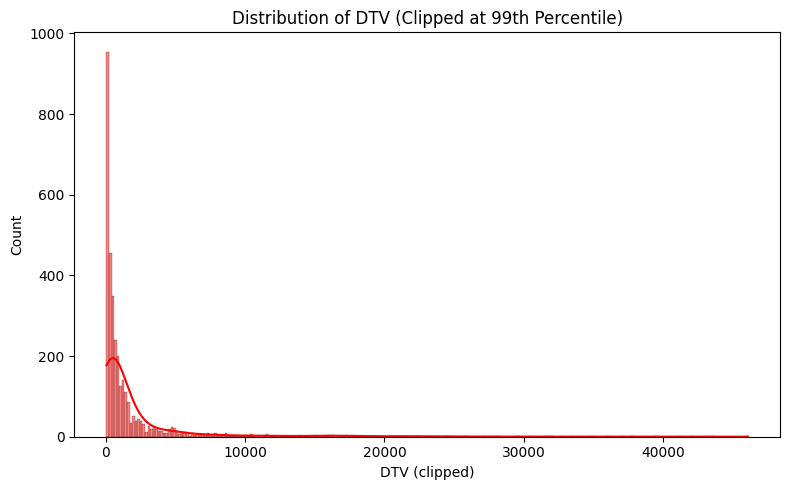

Clipped at 99th percentile of DTV: 46565.00
Shape before clipping: (3470, 12) Shape after clipping: (3435, 12)


In [37]:
import numpy as np
pct_99 = np.percentile(df['DTV'], 99)
df_clipped = df[df['DTV'] <= pct_99]

plt.figure(figsize=(8,5))
sns.histplot(data=df_clipped, x='DTV', kde=True, color='red')
plt.title('Distribution of DTV (Clipped at 99th Percentile)')
plt.xlabel('DTV (clipped)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Clipped at 99th percentile of DTV: {pct_99:.2f}")
print("Shape before clipping:", df.shape, "Shape after clipping:", df_clipped.shape)

## 7. Summary of Findings & Next Steps

1. **Data Cleaning**:
   - We removed rows missing critical columns.
   - Confirmed heavy skew in DTV.
2. **Descriptive Statistics**:
   - Many stations have lower traffic, few have extremely high traffic.
   - Distribution is highly skewed.
3. **Chi-Squared**:
   - We tested whether there's an association between `Kanton` and `EVU`.
   - If p-value < 0.05, there's a significant association.
4. **ANOVA** (DTV by Kanton):
   - We tested if at least one canton differs in mean DTV.
   - If p-value < 0.05, investigate further (e.g., Tukey’s HSD).
5. **Correlation**:
   - We checked how `DTV` relates to `DWV` and `DNWV`.

### Possible Next Steps
- **Filter by Year** (e.g., compare 2022 vs. 2023).
- **Investigate EVU** differences in traffic.
- **Geospatial Analysis**: Plot stations on a map (with `lon` & `lat`) colored by traffic volume. Libraries like `folium` or `geopandas` are handy.
- **Regression Models**: Predict DTV based on location, operator, or other features.

## End of Notebook
We hope this provides a **great in-depth** starting point for your Swiss train station dataset analysis!